**BREAST CANCER DIAGNOSIS PREDICTION SYSTEM:**

Breast cancer remains one of the most prevalent and life-threatening diseases among women worldwide. Early and accurate diagnosis is crucial for effective treatment and improved patient outcomes. This project aims to build a Breast Cancer Diagnosis Prediction System using classical machine learning (ML) and deep learning (DL) techniques to classify tumors as either Benign (B) or Malignant (M) based on key diagnostic features derived from cell nuclei in digitized images.


In this notebook, we:
* Load and preprocess the breast cancer dataset
* Explore the data visually and statistically
* Train and evaluate multiple ML models including:
** Logistic Regression
** Random Forest
** Gradient Boosting
** Fully Connected Neural Network (FCNN)
* Perform stratified K-Fold cross-validation across multiple seeds
* Analyze performance metrics such as Accuracy, Precision, Recall, and F1-Score
* Visualize confusion matrices and compare models side-by-side

In [1]:

#Dependencies and setup
!pip install -U gdown
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
import warnings

# Scikit-learn components
from sklearn.base import clone  # Added this import
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Keras components
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings("ignore")

### **About the WDBC Dataset**

This dataset contains **breast cancer diagnostic data** used for binary classification — predicting whether a tumor is **malignant (M)** or **benign (B)** based on cell nucleus features.

- It includes **30 numeric features** such as radius, texture, perimeter, area, smoothness, etc., calculated from digitized images of fine needle aspirates (FNA) of breast masses.
- The **target variable** is `diagnosis`, with values:
  - `M` → Malignant (cancerous)
  - `B` → Benign (non-cancerous)

📥 **Source of dataset**:  
[Google Drive Link](https://drive.google.com/file/d/1fbHueLVP7UOPLd5tFSuNFVwQtdFMMyYU/view?usp=sharing)



In [24]:
# Download dataset
file_id = "1fbHueLVP7UOPLd5tFSuNFVwQtdFMMyYU"
url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(url, "mydata.csv", quiet=False)

# Define and load data
column_names = [
    'id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
    'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean',
    'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se',
    'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se',
    'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst',
    'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst',
    'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst',
    'fractal_dimension_worst'
]

df = pd.read_csv('mydata.csv', header=None, names=column_names)
print(df.head())
df.drop('id', axis=1, inplace=True)

Downloading...
From: https://drive.google.com/uc?id=1fbHueLVP7UOPLd5tFSuNFVwQtdFMMyYU
To: /content/mydata.csv
100%|██████████| 124k/124k [00:00<00:00, 15.8MB/s]

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_wor

### Exploratory Data Analysis (EDA)

- Visualized class distribution (Malignant vs. Benign).
- Analyzed feature correlations with diagnosis using a heatmap.

### Data Preprocessing

- Separated features (`X`) and labels (`y`).
- Encoded labels: Malignant = 1, Benign = 0.
- Standardized features with `StandardScaler`.
- Split data into train/test sets (80/20) with stratification.


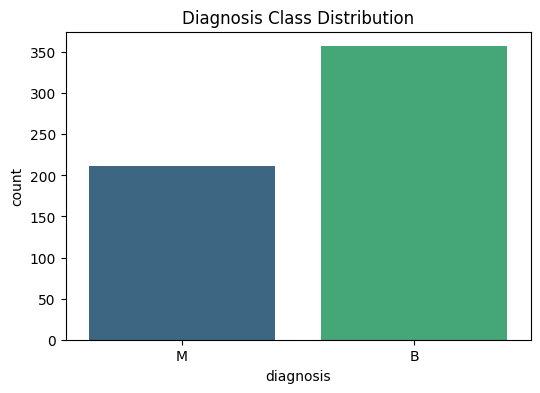

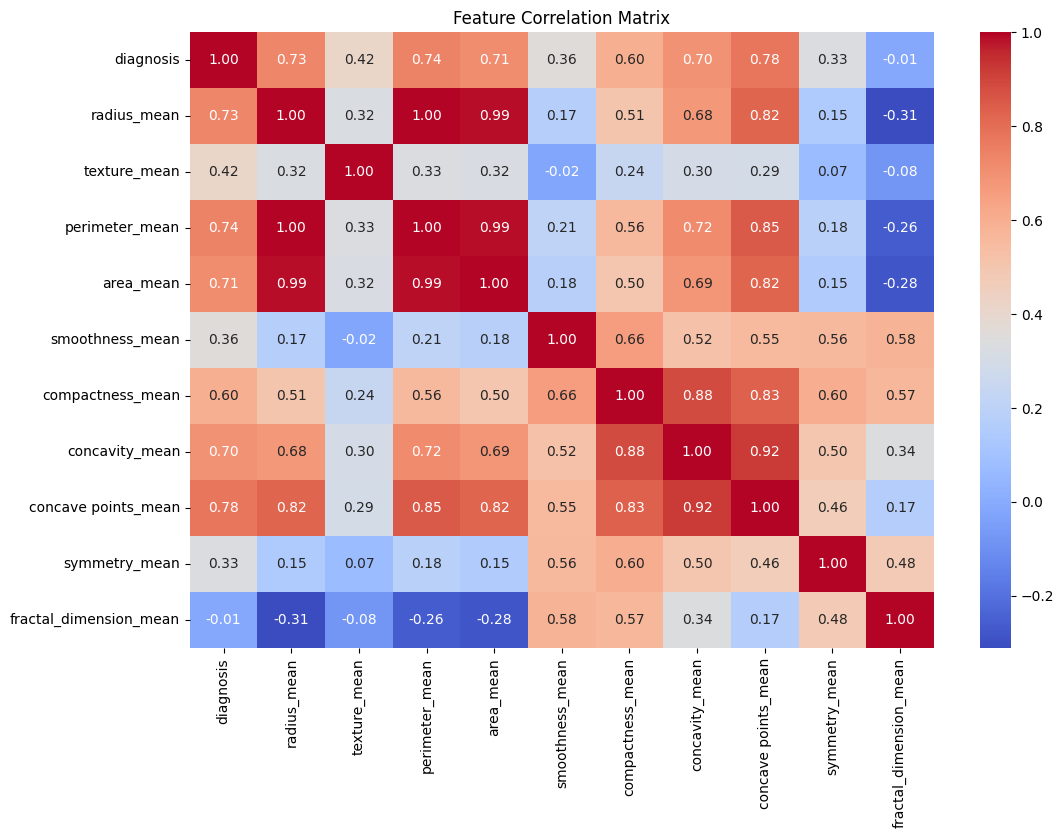

Number of observations in X_train_scaled: 455
Number of observations in X_test_scaled: 114


In [25]:
# Diagnosis distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='diagnosis', data=df, palette='viridis')
plt.title('Diagnosis Class Distribution')
plt.show()

# Correlation analysis
mean_features = ['diagnosis'] + [col for col in df.columns if 'mean' in col]
temp = df[mean_features].copy()
temp['diagnosis'] = temp['diagnosis'].map({'M':1, 'B':0})

plt.figure(figsize=(12, 8))
sns.heatmap(temp.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.show()

# X and y

X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42 # Split X before scaling
)

# Scale features after splitting
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # Fit and transform on training data
X_test_scaled = scaler.transform(X_test) # Transform test data

print(f"Number of observations in X_train_scaled: {X_train_scaled.shape[0]}")
print(f"Number of observations in X_test_scaled: {X_test_scaled.shape[0]}")


### Model Definitions

- **Classic Machine Learning Models (`ml_models`):**
  - **Logistic Regression**: Linear classifier with increased iterations for convergence.
  - **Random Forest**: Ensemble of 400 decision trees with fixed random seed.
  - **Gradient Boosting**: Sequential tree model with 600 estimators, low learning rate, and depth control.

- **Fully Connected Neural Network (FCNN)**:
  - Two hidden layers (128 and 64 units) with ReLU and dropout (30%, 20%).
  - Output layer with sigmoid activation for binary classification.
  - Compiled with Adam optimizer, binary cross-entropy loss, and accuracy as metric.


In [26]:

ml_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=400, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=600, learning_rate=0.01,
                                                  max_depth=4, random_state=42)
}

def build_fcnn(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


### Cross-Validation Framework

- Models are evaluated using 5-fold stratified cross-validation with 3 different random seeds for robustness.
- Metrics computed: Accuracy, Precision, Recall, F1 Score, and Confusion Matrix.
- Classical models are cloned and evaluated per fold; results are averaged and stored.
- FCNN uses the same process with early stopping and sigmoid thresholding.
- Results are stored in `metrics_results` for further analysis.


In [19]:
# CROSS-VALIDATION FRAMEWORK

seeds = [1, 7, 42]
n_splits = 5

metrics_results = {
    model: {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'conf_matrices': []}
    for model in list(ml_models.keys()) + ['FCNN']
}

for seed in seeds:
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    # Classical ML Models
    for name, model in ml_models.items():
        accs, precs, recalls, f1s, conf_mats = [], [], [], [], []

        for train_idx, test_idx in kfold.split(X_train_scaled, y_train): # Use X_train_scaled and y_train for splitting within CV
            X_train_cv, X_test_cv = X_train_scaled[train_idx], X_train_scaled[test_idx]
            y_train_cv, y_test_cv = y_train[train_idx], y_train[test_idx]

            current_model = clone(model)
            current_model.fit(X_train_cv, y_train_cv)
            y_pred = current_model.predict(X_test_cv)

            accs.append(accuracy_score(y_test_cv, y_pred))
            precs.append(precision_score(y_test_cv, y_pred))
            recalls.append(recall_score(y_test_cv, y_pred))
            f1s.append(f1_score(y_test_cv, y_pred))
            conf_mats.append(confusion_matrix(y_test_cv, y_pred))

        metrics_results[name]['accuracy'].append(np.mean(accs))
        metrics_results[name]['precision'].append(np.mean(precs))
        metrics_results[name]['recall'].append(np.mean(recalls))
        metrics_results[name]['f1'].append(np.mean(f1s))
        metrics_results[name]['conf_matrices'].append(conf_mats[-1])

    # FCNN Model
    fcnn_histories = [] # Initialize list to store FCNN histories
    accs, precs, recalls, f1s, conf_mats = [], [], [], [], []
    for train_idx, test_idx in kfold.split(X_train_scaled, y_train): # Use X_train_scaled and y_train for splitting within CV
        X_train_cv, X_test_cv = X_train_scaled[train_idx], X_train_scaled[test_idx]
        y_train_cv, y_test_cv = y_train[train_idx], y_train[test_idx]

        model = build_fcnn(X_train_cv.shape[1])
        es = EarlyStopping(patience=5, restore_best_weights=True)

        history = model.fit( # Store history object
            X_train_cv, y_train_cv,
            epochs=1000,
            batch_size=32,
            validation_split=0.1,
            callbacks=[es],
            verbose=0
        )

        fcnn_histories.append(history.history) # Append history to list

        y_pred = (model.predict(X_test_cv).flatten() > 0.5).astype(int)

        accs.append(accuracy_score(y_test_cv, y_pred))
        precs.append(precision_score(y_test_cv, y_pred))
        recalls.append(recall_score(y_test_cv, y_pred))
        f1s.append(f1_score(y_test_cv, y_pred))
        conf_mats.append(confusion_matrix(y_test_cv, y_pred))

    metrics_results['FCNN']['accuracy'].append(np.mean(accs))
    metrics_results['FCNN']['precision'].append(np.mean(precs))
    metrics_results['FCNN']['recall'].append(np.mean(recalls))
    metrics_results['FCNN']['f1'].append(np.mean(f1s))
    metrics_results['FCNN']['conf_matrices'].append(conf_mats[-1])

metrics_results['FCNN']['fcnn_histories'] = fcnn_histories # Add histories to metrics_results

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


## Process training history data

Process the collected history data from the cross-validation folds (e.g., calculate average history across folds). Access the FCNN training histories, determine the minimum number of epochs, and then compute the average of each metric across all histories up to that minimum length.


In [27]:
# Process FCNN training histories
fcnn_histories = metrics_results['FCNN']['fcnn_histories']

# Determine the minimum number of epochs across all histories
min_epochs = min(len(history['loss']) for history in fcnn_histories)

# Create a dictionary to store the averaged metrics
avg_fcnn_history = {
    'loss': np.zeros(min_epochs),
    'accuracy': np.zeros(min_epochs),
    'val_loss': np.zeros(min_epochs),
    'val_accuracy': np.zeros(min_epochs)
}

# Sum the metrics across all histories up to the minimum number of epochs
for history in fcnn_histories:
    for metric in avg_fcnn_history.keys():
        avg_fcnn_history[metric] += np.array(history[metric][:min_epochs])

# Calculate the average by dividing by the number of histories
num_histories = len(fcnn_histories)
for metric in avg_fcnn_history.keys():
    avg_fcnn_history[metric] /= num_histories

# Display the shape of the averaged history arrays to verify
print("Shape of averaged FCNN history metrics:")
for metric, values in avg_fcnn_history.items():
    print(f"{metric}: {values.shape}")

Shape of averaged FCNN history metrics:
loss: (9,)
accuracy: (9,)
val_loss: (9,)
val_accuracy: (9,)


## Visualize FCNN training history



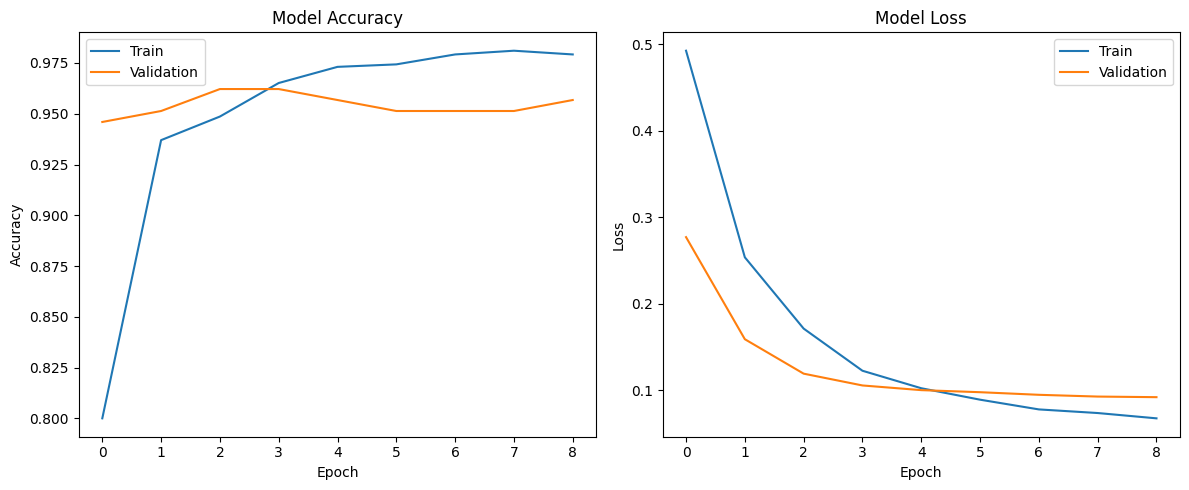

In [35]:
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(avg_fcnn_history['accuracy'], label='Train')
plt.plot(avg_fcnn_history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(avg_fcnn_history['loss'], label='Train')
plt.plot(avg_fcnn_history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

### Results Visualization

- A summary table reports each model's mean Accuracy (± standard deviation), Precision, Recall, and F1 Score, sorted by Accuracy.
- A horizontal bar chart compares model accuracies with error bars to show variability across cross-validation folds.
- Confusion matrices for each model.



=== CROSS-VALIDATION RESULTS ===
              Model        Accuracy Precision Recall     F1
Logistic Regression 0.9744 ± 0.0010    0.9806 0.9510 0.9650
               FCNN 0.9714 ± 0.0036    0.9685 0.9549 0.9612
      Random Forest 0.9575 ± 0.0027    0.9568 0.9294 0.9418
  Gradient Boosting 0.9421 ± 0.0085    0.9300 0.9157 0.9217


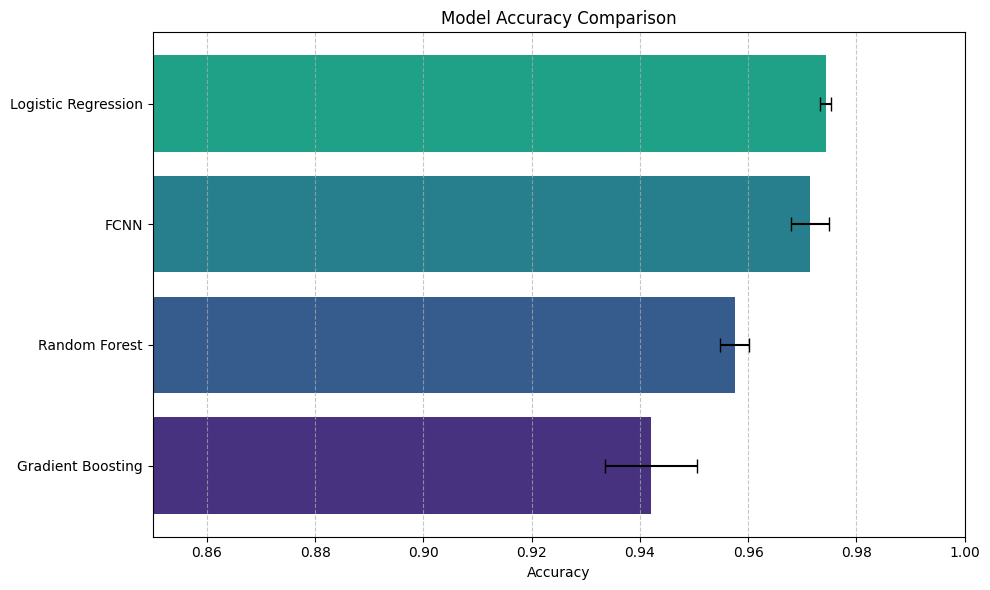

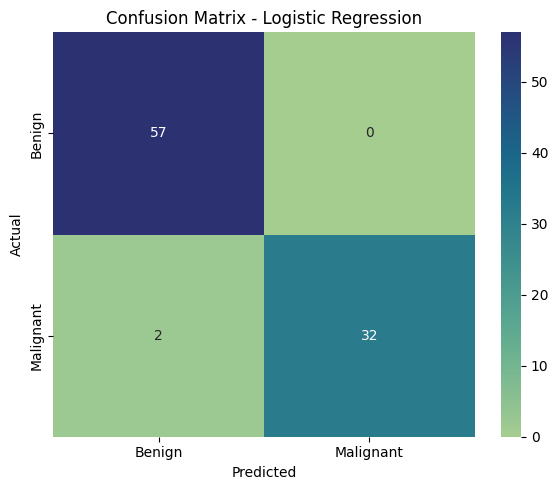

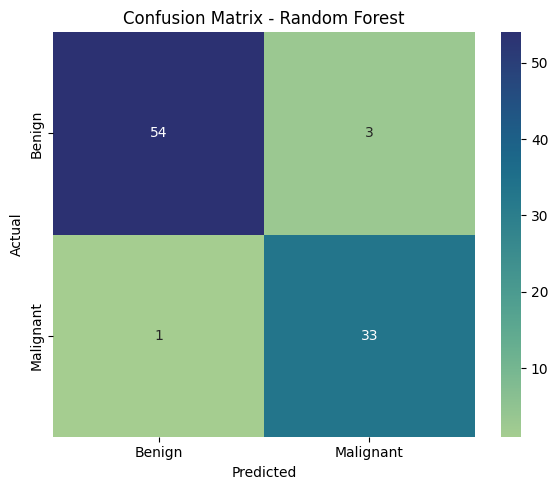

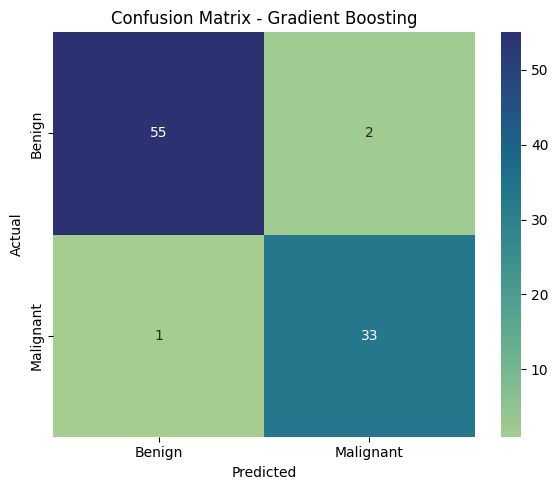

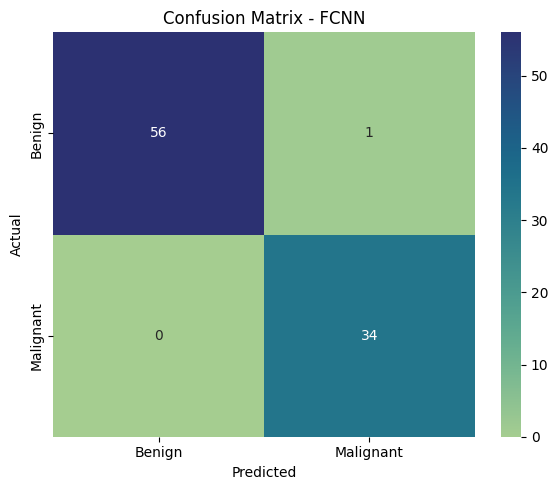

In [36]:
#RESULTS

# Summary table
summary_metrics = []
for model, metric in metrics_results.items():
    summary_metrics.append({
        'Model': model,
        'Accuracy': f"{np.mean(metric['accuracy']):.4f} ± {np.std(metric['accuracy']):.4f}",
        'Precision': f"{np.mean(metric['precision']):.4f}",
        'Recall': f"{np.mean(metric['recall']):.4f}",
        'F1': f"{np.mean(metric['f1']):.4f}"
    })

metrics_df = pd.DataFrame(summary_metrics).sort_values(by='Accuracy', ascending=False)
print("\n=== CROSS-VALIDATION RESULTS ===")
print(metrics_df.to_string(index=False))

# Accuracy comparison plot
acc_data = []
for model, metric in metrics_results.items():
    acc_data.append({
        'Model': model,
        'Mean Accuracy': np.mean(metric['accuracy']),
        'Std': np.std(metric['accuracy'])
    })

acc_df = pd.DataFrame(acc_data).sort_values('Mean Accuracy')

plt.figure(figsize=(10, 6))
plt.barh(acc_df['Model'], acc_df['Mean Accuracy'], xerr=acc_df['Std'],
         color=sns.color_palette("viridis"), capsize=5)
plt.title("Model Accuracy Comparison")
plt.xlabel("Accuracy")
plt.xlim(0.85, 1.0)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# CONFUSION MATRICES

for model_name, result in metrics_results.items():
    cm = result['conf_matrices'][0]  # Take the confusion matrix from the last fold
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='crest',
                xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


ROC Curves

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


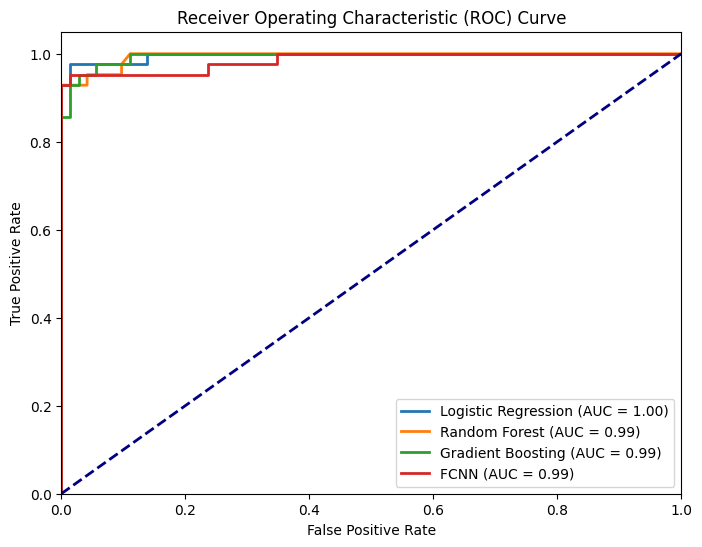

In [37]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))

# Plot for each model
for name, model in ml_models.items():
    model.fit(X_train_scaled, y_train) # Use X_train_scaled for fitting
    y_prob = model.predict_proba(X_test_scaled)[:, 1] # Use X_test_scaled for prediction
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot for FCNN
# Re-train the FCNN model on the full training data (X_train_scaled, y_train) for ROC curve
fcnn_model_roc = build_fcnn(X_train_scaled.shape[1])
fcnn_model_roc.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0) # Train on X_train_scaled, y_train

y_prob = fcnn_model_roc.predict(X_test_scaled).flatten() # Predict on X_test_scaled
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'FCNN (AUC = {roc_auc:.2f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [40]:
# Train Final Models

final_ml_models = {}
for name, model in ml_models.items():
    print(f"Training final {name} model...")
    final_ml_models[name] = clone(model) # Use clone to get a fresh instance
    final_ml_models[name].fit(X_train_scaled, y_train)


# Train final FCNN model
print("Training final FCNN model...")
final_fcnn_model = build_fcnn(X_train_scaled.shape[1])
es = EarlyStopping(patience=10, restore_best_weights=True) # Use a slightly higher patience for final model

final_fcnn_model.fit(
    X_train_scaled, y_train,
    epochs=1000,
    batch_size=32,
    validation_split=0.1, # Still use validation split for monitoring/early stopping during final training
    callbacks=[es],
    verbose=0
)

print("Final model training complete.")

Training final Logistic Regression model...
Training final Random Forest model...
Training final Gradient Boosting model...
Training final FCNN model...
Final model training complete.


In [45]:
# Architecture of the final FCNN model
print(final_fcnn_model.summary())

# Display shapes of weights and biases for each layer in the final FCNN model
print("Weights and Biases Shapes for FCNN Layers:")
for i, layer in enumerate(final_fcnn_model.layers):
    if isinstance(layer, Dense):
        weights, biases = layer.get_weights()
        print(f"Layer {i} ({layer.name}):")
        print(f"  Weights shape: {weights.shape}")
        print(f"  Biases shape: {biases.shape}")

# the actual values:
print("\nExample Weights for the first Dense layer:")
print(final_fcnn_model.layers[0].get_weights()[0][0:5, 0:5])



Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_99 (Dense)                │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,869 (144.02 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 24,580 (96.02 KB)

None
Weights and Biases Shapes for FCNN Layers:
Layer 0 (dense_99):
  Weights shape: (30, 128)
  Biases shape: (128,)
Layer 2 (dense_100):
  Weights shape: (128, 64)
  Biases shape: (64,)
Layer 4 (dense_101):
  Weights shape: (64, 1)
  Biases shape: (1,)

Example Weights for the first Dense layer:
[[-0.17742124 -0.03448776 -0.11668618  0.03548514  0.12310845]
 [ 0.07856061 -0.20283733  0.07735448 -0.04534326  0.03891792]
 [-0.09332121  0.10363015 -0.00806557  0.12375534  0.07795022]
 [-0.02430529 -0.17309293 -0.0183554   0.02810757  0.01171558]
 [-0.16186921 -0.16926026 -0.01253349 -0.0079719   0.17344701]]



=== FINAL TEST SET RESULTS ===


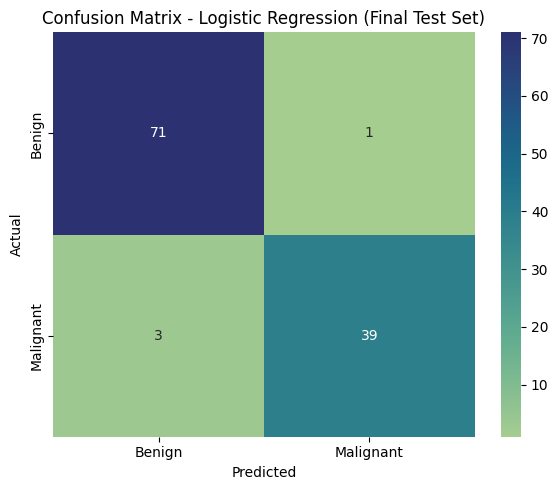

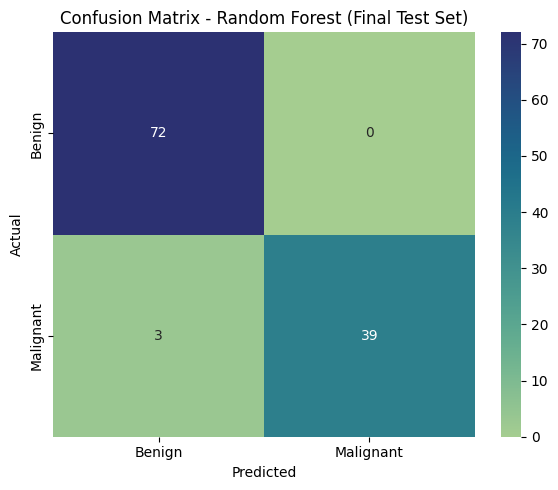

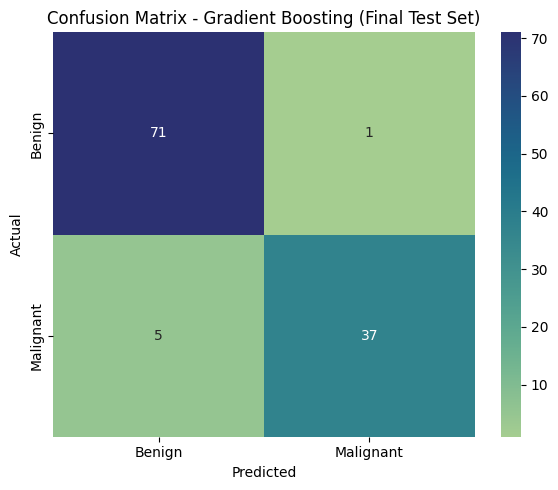

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


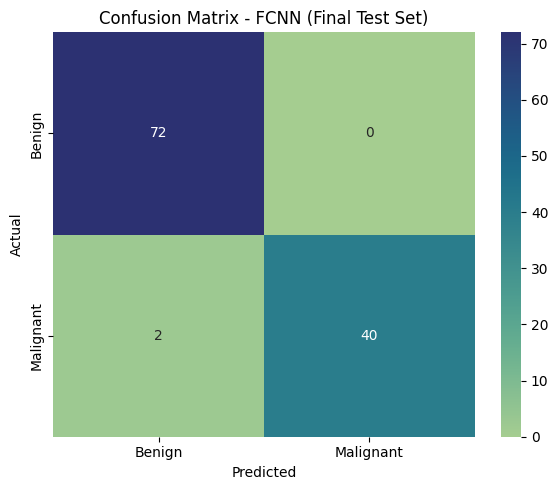


=== FINAL TEST SET METRICS SUMMARY ===
              Model  Accuracy  Precision   Recall       F1
               FCNN  0.982456   1.000000 0.952381 0.975610
      Random Forest  0.973684   1.000000 0.928571 0.962963
Logistic Regression  0.964912   0.975000 0.928571 0.951220
  Gradient Boosting  0.947368   0.973684 0.880952 0.925000


In [41]:
# Evaluate on Test Set and Display Results

final_metrics = []

print("\n=== FINAL TEST SET RESULTS ===")

# Evaluate Classical ML Models
for name, model in final_ml_models.items():
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    final_metrics.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1
    })

    # Display Confusion Matrix for Classical ML Models
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='crest',
                xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'])
    plt.title(f"Confusion Matrix - {name} (Final Test Set)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# Evaluate Final FCNN Model
y_pred_fcnn = (final_fcnn_model.predict(X_test_scaled).flatten() > 0.5).astype(int)
acc_fcnn = accuracy_score(y_test, y_pred_fcnn)
prec_fcnn = precision_score(y_test, y_pred_fcnn)
rec_fcnn = recall_score(y_test, y_pred_fcnn)
f1_fcnn = f1_score(y_test, y_pred_fcnn)
cm_fcnn = confusion_matrix(y_test, y_pred_fcnn)

final_metrics.append({
    'Model': 'FCNN',
    'Accuracy': acc_fcnn,
    'Precision': prec_fcnn,
    'Recall': rec_fcnn,
    'F1': f1_fcnn
})

# Display Confusion Matrix for FCNN
plt.figure(figsize=(6, 5))
sns.heatmap(cm_fcnn, annot=True, fmt='d', cmap='crest',
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.title(f"Confusion Matrix - FCNN (Final Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Display Summary Table
final_metrics_df = pd.DataFrame(final_metrics).sort_values(by='Accuracy', ascending=False)
print("\n=== FINAL TEST SET METRICS SUMMARY ===")
print(final_metrics_df.to_string(index=False))